In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, Conv1D, Bidirectional
from tensorflow.keras.models import load_model
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import warnings
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, SpatialDropout1D, Add,
    GRU, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense,
    Dropout, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [73]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        """Download dataset using kagglehub."""
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        """Load training and testing datasets."""
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [74]:
# Initialize pipeline
pipeline = NetworkTrafficPipeline()
    
# Download and load data
path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


In [75]:
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import umap
import warnings

warnings.filterwarnings('ignore')

class UNSWPreprocessor:
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame, val_size: float = 0.2):
        self.original_train = train_data.copy()
        self.original_test = test_data.copy()
        self.train_data = train_data.copy()
        self.test_data = test_data.copy()
        self.val_size = val_size
        self.target_col = 'attack_cat'
        
        # Configurações
        self.min_samples = 150
        self.corr_threshold = 0.85
        self.final_features = 20
        self.unknown_label_token = "UNKNOWN"
        
        # Componentes
        self.label_encoders: Dict[str, LabelEncoder] = {}
        self.umap = umap.UMAP(n_components=15, random_state=42)

    def _get_numeric_cols(self, df: pd.DataFrame) -> List[str]:
        """Retorna colunas numéricas excluindo o target"""
        return [col for col in df.select_dtypes(include=np.number).columns 
                if col != self.target_col]

    def _handle_duplicates(self):
        """Etapa 1/12: Remoção de duplicatas"""
        initial = len(self.train_data)
        self.train_data = self.train_data.drop_duplicates()
        print(f"✅ Removidas {initial - len(self.train_data)} duplicatas")

    def _handle_missing_values(self):
        """Etapa 2/12: Tratamento de valores faltantes com categorias"""
        for df in [self.train_data, self.test_data]:
            # Para colunas categóricas
            categorical_cols = df.select_dtypes(include=['category', 'object']).columns
            for col in categorical_cols:
                if col == self.target_col:
                    continue
                
                # Converter para categoria se necessário
                if not pd.api.types.is_categorical_dtype(df[col]):
                    df[col] = df[col].astype('category')
            
                # Adicionar categoria 'UNKNOWN' se não existir
                if self.unknown_label_token not in df[col].cat.categories:
                    df[col] = df[col].cat.add_categories(self.unknown_label_token)
            
                # Preencher valores faltantes
                df[col] = df[col].fillna(self.unknown_label_token)
        
            # Para colunas numéricas
            numeric_cols = self._get_numeric_cols(df)
            df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    def _encode_categorical_features(self):
        """Etapa 3/12: Codificação categórica"""
        categorical_cols = self.train_data.select_dtypes(exclude=np.number).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != self.target_col]
        
        for col in categorical_cols:
            le = LabelEncoder()
            combined = pd.concat([self.train_data[col], self.test_data[col]], axis=0)
            le.fit(combined.astype(str))
            
            self.train_data[col] = le.transform(self.train_data[col].astype(str))
            self.test_data[col] = le.transform(self.test_data[col].astype(str))
            self.label_encoders[col] = le

        # Codificar target
        self.label_encoder_target = LabelEncoder()
        self.train_data[self.target_col] = self.label_encoder_target.fit_transform(self.train_data[self.target_col])
        self.test_data[self.target_col] = self.label_encoder_target.transform(self.test_data[self.target_col])

    def _advanced_feature_engineering(self):
        """Etapa 4/12: Engenharia de features"""
        required_columns = {'spkts', 'dpkts', 'dur', 'sbytes', 'dbytes'}
        
        for df in [self.train_data, self.test_data]:
            missing = required_columns - set(df.columns)
            if missing:
                print(f"⚠️ Colunas ausentes: {missing}. Ignorando criação de features.")
                continue
                
            # Garantir tipos numéricos
            for col in required_columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            # Novas features
            df['flow_intensity'] = np.log1p(df['spkts'] + df['dpkts'])
            df['packet_velocity'] = (df['spkts'] + df['dpkts']) / df['dur'].replace(0, 1e-8)
            df['byte_asymmetry'] = (df['sbytes'] - df['dbytes']) / (df['sbytes'] + df['dbytes'] + 1e-8)

    def _filter_classes(self):
        """Etapa 5/12: Filtragem de classes minoritárias"""
        class_counts = self.train_data[self.target_col].value_counts()
        valid_classes = class_counts[class_counts >= self.min_samples].index
        self.train_data = self.train_data[self.train_data[self.target_col].isin(valid_classes)]

    def _remove_redundant_features(self):
        """Etapa 6/12: Remoção de features redundantes"""
        cols_to_drop = ['srcip', 'sport', 'dstip', 'dsport', 'label']
        self.train_data.drop(columns=cols_to_drop, errors='ignore', inplace=True)
        self.test_data.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    def _validate_feature_correlation(self):
        """Etapa 7/12: Validação de correlação"""
        numeric_cols = self._get_numeric_cols(self.train_data)
        X = self.train_data[numeric_cols]
        y = self.train_data[self.target_col]
        
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X, y)
        
        result = permutation_importance(model, X, y, n_repeats=5, random_state=42)
        features_to_keep = X.columns[result.importances_mean > 0.01].tolist()
        
        # Garantir colunas essenciais
        essential_cols = {'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes'}
        features_to_keep = list(set(features_to_keep) | essential_cols)
        
        self.train_data = self.train_data[features_to_keep + [self.target_col]]
        self.test_data = self.test_data[features_to_keep + [self.target_col]]

    def _handle_outliers(self):
        """Etapa 8/12: Tratamento de outliers"""
        numeric_cols = self._get_numeric_cols(self.train_data)
        
        for col in numeric_cols:
            if col not in self.train_data.columns:
                continue
                
            q1 = self.train_data[col].quantile(0.25)
            q3 = self.train_data[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            
            self.train_data[col] = np.clip(self.train_data[col], lower, upper)
            self.test_data[col] = np.clip(self.test_data[col], lower, upper)

    def _hybrid_feature_selection(self):
        """Etapa 9/12: Seleção hierárquica de features"""
        numeric_cols = self._get_numeric_cols(self.train_data)
        X = self.train_data[numeric_cols]
        y = self.train_data[self.target_col]
        
        selector = SelectKBest(mutual_info_classif, k=30)
        X_filtered = selector.fit_transform(X, y)
        selected_features = X.columns[selector.get_support()]
        
        rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
        rfe.fit(X_filtered, y)
        
        # Atualizar dados
        self.train_data = pd.DataFrame(
            rfe.transform(X_filtered),
            columns=selected_features[rfe.support_],
            index=X.index
        ).join(self.train_data[[self.target_col]])
        
        self.test_data = pd.DataFrame(
            rfe.transform(selector.transform(self.test_data[numeric_cols])),
            columns=selected_features[rfe.support_],
            index=self.test_data.index
        ).join(self.test_data[[self.target_col]])

    def _balanced_sampling(self):
        """Etapa 10/12: Balanceamento de classes"""
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        
        smote = SMOTENC(
            categorical_features=[i for i, col in enumerate(X.columns) 
                                if col in self.label_encoders],
            random_state=42
        )
        X_res, y_res = smote.fit_resample(X, y)
        self.train_data = pd.DataFrame(X_res, columns=X.columns).join(pd.Series(y_res, name=self.target_col))

    def _apply_umap(self):
        """Etapa 11/12: Redução de dimensionalidade"""
        reducer = umap.UMAP(n_components=15, random_state=42)
        umap_features = reducer.fit_transform(self.train_data.drop(columns=[self.target_col]))
        self.train_data = pd.DataFrame(umap_features).join(self.train_data[[self.target_col]])
        
        umap_test = reducer.transform(self.test_data.drop(columns=[self.target_col]))
        self.test_data = pd.DataFrame(umap_test).join(self.test_data[[self.target_col]])

    def _contrastive_learning_sampling(self):
        """Etapa 12/12: Redução de overlap entre classes"""
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        
        cov_matrix = np.cov(X.T)
        inv_cov = np.linalg.pinv(cov_matrix)
        distances = pairwise_distances(X, metric='mahalanobis', VI=inv_cov)
        
        overlap_indices = np.unique(np.where(distances < np.percentile(distances, 5))[0])
        self.train_data = self.train_data.drop(index=overlap_indices)
        print(f"✅ Redução de overlap: {len(overlap_indices)} amostras removidas")

    def preprocess(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.Series, pd.Series, pd.Series]:
        """Pipeline completo com 12 etapas"""
        processing_steps = [
            self._handle_duplicates,               # Etapa 1
            self._handle_missing_values,           # Etapa 2
            self._encode_categorical_features,     # Etapa 3
            self._advanced_feature_engineering,    # Etapa 4
            self._filter_classes,                  # Etapa 5
            self._remove_redundant_features,       # Etapa 6
            self._validate_feature_correlation,    # Etapa 7
            self._handle_outliers,                 # Etapa 8
            self._hybrid_feature_selection,        # Etapa 9
            self._balanced_sampling,               # Etapa 10
            self._apply_umap,                      # Etapa 11
            self._contrastive_learning_sampling    # Etapa 12
        ]

        for step, method in enumerate(processing_steps, 1):
            print(f"🚀 Executando etapa {step}/12: {method.__name__}")
            method()

        # Split final
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size, stratify=y)
        
        return (
            X_train.values.astype(np.float32),
            X_val.values.astype(np.float32),
            self.test_data.drop(columns=[self.target_col]).values.astype(np.float32),
            y_train,
            y_val,
            self.test_data[self.target_col]
        )

    def plot_class_distribution(self, y: pd.Series, title: str):
        """Visualização da distribuição de classes"""
        plt.figure(figsize=(14,7))
        decoded = self.label_encoder_target.inverse_transform(y)
        ax = sns.countplot(x=decoded, palette='viridis')
        plt.title(f'Distribuição de Classes - {title}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Categoria de Ataque', fontsize=12)
        plt.ylabel('Contagem', fontsize=12)
        
        for p in ax.patches:
            ax.annotate(f'{p.get_height():,}', 
                       (p.get_x()+p.get_width()/2., p.get_height()),
                       ha='center', va='center', 
                       xytext=(0, 5), 
                       textcoords='offset points',
                       fontsize=9)
            
        plt.tight_layout()
        plt.show()

In [78]:
from typing import Dict, List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import umap
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import pairwise_distances
from sklearn.utils import class_weight
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from boruta import BorutaPy
from scipy.stats import ks_2samp
import json

warnings.filterwarnings('ignore')

class UNSWPreprocessor:
    def __init__(self, train_data: pd.DataFrame, test_data: pd.DataFrame, val_size: float = 0.2):
        self.original_train = train_data.copy()
        self.original_test = test_data.copy()
        self.train_data = train_data.copy()
        self.test_data = test_data.copy()
        self.val_size = val_size
        self.target_col = 'attack_cat'
        
        # Configurações avançadas
        self.min_samples = 500
        self.corr_threshold = 0.85
        self.variance_threshold = 0.95
        self.contamination = 0.01
        
        # Componentes
        self.label_encoders: Dict[str, LabelEncoder] = {}
        self.target_encoders: Dict[str, TargetEncoder] = {}
        self.boruta = BorutaPy(estimator=RandomForestClassifier(n_jobs=-1), n_estimators='auto', verbose=0)
        self.shap_explainer = None
        self.report_data = {}
        self.label_encoder_target = LabelEncoder()
        self.train_data[self.target_col] = self.label_encoder_target.fit_transform(self.train_data[self.target_col])
        self.test_data[self.target_col] = self.label_encoder_target.transform(self.test_data[self.target_col])

    def _get_numeric_cols(self, df: pd.DataFrame) -> List[str]:
        return [col for col in df.select_dtypes(include=np.number).columns 
                if col != self.target_col]

    def _domain_validation(self):
        """Etapa 1/14: Validação de domínio e sanity checks"""
        # Remover registros inválidos
        invalid_condition = (
            (self.train_data['dur'] == 0) & 
            (self.train_data['spkts'] > 0)
        )
        self.train_data = self.train_data[~invalid_condition]
        
    
        # Split estratificado inicial
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X, y, test_size=self.val_size, stratify=y, random_state=42
        )
        self.train_data = pd.concat([self.X_train, self.y_train], axis=1)

    def _mice_imputation(self):
        """Etapa 2/14: Imputação multivariada com MICE"""
        numeric_cols = self._get_numeric_cols(self.train_data)
        categorical_cols = list(set(self.train_data.columns) - set(numeric_cols) - {self.target_col})
        
        # Imputação numérica
        imputer = IterativeImputer(max_iter=10, random_state=42)
        self.train_data[numeric_cols] = imputer.fit_transform(self.train_data[numeric_cols])
        self.test_data[numeric_cols] = imputer.transform(self.test_data[numeric_cols])
        
        # Flags para valores imputados
        for col in numeric_cols:
            self.train_data[f'is_missing_{col}'] = self.train_data[col].isnull().astype(int)
            self.test_data[f'is_missing_{col}'] = self.test_data[col].isnull().astype(int)

    def _advanced_encoding(self):
        """Etapa 3/14: Codificação avançada"""
        high_cardinality_cols = ['service', 'proto']
        
        for col in high_cardinality_cols:
            # Converter para string (evitar problemas de tipo)
            self.train_data[col] = self.train_data[col].astype(str)
            self.test_data[col] = self.test_data[col].astype(str)
            
            # Usar target_type='continuous' e smooth automático
            encoder = TargetEncoder(target_type='continuous', smooth='auto')
            
            # Aplicar codificação
            encoded_train = encoder.fit_transform(
                self.train_data[[col]],  # DataFrame 2D
                self.train_data[self.target_col]  # Target já codificado
            )
            self.train_data[col] = encoded_train.ravel()  # Converter para 1D
            
            encoded_test = encoder.transform(self.test_data[[col]])
            self.test_data[col] = encoded_test.ravel()
            
            self.target_encoders[col] = encoder  # Armazenar o encoder

        # Label Encoding para outras categóricas
        other_categorical = list(
            set(self.train_data.select_dtypes(include=['object', 'category']).columns) - 
            set(high_cardinality_cols)
        )
    
        for col in other_categorical:
            le = LabelEncoder()
            combined = pd.concat([self.train_data[col], self.test_data[col]], axis=0)
            le.fit(combined.astype(str))
            self.train_data[col] = le.transform(self.train_data[col].astype(str))
            self.test_data[col] = le.transform(self.test_data[col].astype(str))
            self.label_encoders[col] = le

    def _hybrid_feature_engineering(self):
        """Etapa 4/14: Engenharia de features contextual aprimorada"""
    
        def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
            eps = 1e-8  # Evitar divisão por zero
        
            # --- Features originais ---
            data['burstiness'] = data[['sinpkt', 'dinpkt']].var(axis=1)
            data['session_duration_per_packet'] = data['dur'] / (data['spkts'] + data['dpkts'] + eps)
            data['proto_service_ratio'] = data['proto'] / (data['service'] + eps)
        
            # --- Novas features do usuário ---
            # Taxas e proporções básicas
            data['bytes_per_packet'] = (data['sbytes'] + data['dbytes']) / (data['spkts'] + data['dpkts'] + eps)
            data['bytes_ratio'] = np.log1p(data['sbytes']) - np.log1p(data['dbytes'])
            data['packets_ratio'] = np.log1p(data['spkts']) - np.log1p(data['dpkts'])
            data['packet_rate'] = (data['spkts'] + data['dpkts']) / (data['dur'] + eps)
            data['byte_rate'] = (data['sbytes'] + data['dbytes']) / (data['dur'] + eps)
        
            # Features específicas de origem/destino
            data['srate'] = data['spkts'] / (data['dur'] + eps)
            data['drate'] = data['dpkts'] / (data['dur'] + eps)
            data['sload'] = (data['sbytes'] * data['srate']) / (eps + data['dur'])
            data['dload'] = (data['dbytes'] * data['drate']) / (eps + data['dur'])
        
            # Features baseadas em perda
            data['total_loss_ratio'] = (data['sloss'] + data['dloss']) / (data['spkts'] + data['dpkts'] + eps)
            data['loss_ratio_diff'] = (data['sloss'] / (data['spkts'] + eps)) - (data['dloss'] / (data['dpkts'] + eps))
        
            # Features de conexão (condicionais)
            if 'ct_state_ttl' in data.columns:
                data['conn_ratio'] = data['ct_src_dport_ltm'] / (data['ct_dst_sport_ltm'] + eps)
                data['state_ratio'] = data['ct_state_ttl'] / (data['ct_dst_ltm'] + eps)
                data['ct_dst_src_ratio'] = data['ct_dst_ltm'] / (data['ct_src_dport_ltm'] + eps)
        
            # Features estatísticas
            data['mean_diff'] = data['smean'] - data['dmean']
            data['jitter_ratio'] = np.log1p(data['sjit']) - np.log1p(data['djit'])
        
            # Features de complexidade (condicionais)
            if 'swin' in data.columns and 'dwin' in data.columns:
                data['protocol_complexity'] = data['swin'] * data['dwin']
            if 'tcprtt' in data.columns and 'synack' in data.columns:
                data['tcp_behaviour'] = (data['tcprtt'] * data['synack']) / (data['dur'] + eps)
        
            return data

        # Aplicar a ambos os datasets
        self.train_data = engineer_features(self.train_data)
        self.test_data = engineer_features(self.test_data)
        
    def _balanced_sampling(self):
        """Etapa 5/14: Balanceamento inteligente com limiar e técnicas híbridas"""
        # 1. Remover classes abaixo do threshold
        class_counts = self.train_data[self.target_col].value_counts()
        valid_classes = class_counts[class_counts >= self.min_samples].index
        self.train_data = self.train_data[self.train_data[self.target_col].isin(valid_classes)]

        print(f"Classes removidas: {class_counts[class_counts < self.min_samples].index.tolist()}")
    
        max_balance_ratio = 0.3  # Threshold de 30% para evitar over-balancing
    
        # 1. Limpeza inicial com Tomek Links
        tl = TomekLinks(sampling_strategy='majority')
        X_tl, y_tl = tl.fit_resample(
            self.train_data.drop(columns=[self.target_col]),
            self.train_data[self.target_col]
        )
    
        # 2. Análise de distribuição pós-limpeza
        class_counts = y_tl.value_counts()
        majority_size = class_counts.max()
        minority_size = class_counts.min()
        balance_ratio = minority_size / majority_size
    
        # 3. Aplicar SMOTE apenas se necessário
        if balance_ratio < max_balance_ratio:
            smote = SMOTE(
                ampling_strategy={cls: min(int(count * 1.5), majority_size) 
                              for cls, count in class_counts.items()},
                k_neighbors=2,
                random_state=42
            )
            X_res, y_res = smote.fit_resample(X_tl, y_tl)
            print(f"SMOTE aplicado. Ratio anterior: {balance_ratio:.2%} → Novo ratio: {y_res.value_counts().min()/y_res.value_counts().max():.2%}")
        else:
            X_res, y_res = X_tl, y_tl
            print(f"Balanceamento omitido. Ratio atual: {balance_ratio:.2%} >= {max_balance_ratio:.0%}")

        # 4. Atualizar dados
        self.train_data = pd.concat([X_res, y_res], axis=1)
        self.plot_class_distribution(y_res, "Pós-Balanceamento")
    def _dbscan_overlap_reduction(self):
        """Etapa 6/14: Redução de overlap com DBSCAN"""
        from sklearn.cluster import DBSCAN
        
        dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
        clusters = dbscan.fit_predict(self.train_data.drop(columns=[self.target_col]))
        noise_mask = clusters == -1
        self.train_data = self.train_data[~noise_mask]

    def _boruta_shap_selection(self):
        """Etapa 7/14: Seleção hierárquica de features"""
        # Filtro Boruta
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        self.boruta.fit(X.values, y.values)
        boruta_mask = self.boruta.support_
        
        # Refinamento SHAP
        model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        model.fit(X.loc[:, boruta_mask], y)
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X.loc[:, boruta_mask])
        
        shap_scores = np.abs(shap_values).mean(axis=0)
        selected_features = X.columns[boruta_mask][shap_scores > np.percentile(shap_scores, 75)]
        
        self.train_data = self.train_data[selected_features.tolist() + [self.target_col]]
        self.test_data = self.test_data[selected_features.tolist() + [self.target_col]]

    def _adaptive_dimensionality_reduction(self):
        """Etapa 8/14: Redução de dimensionalidade adaptativa"""
        # PCA Incremental para grandes datasets
        if len(self.train_data) > 1e5:
            pca = IncrementalPCA(n_components=self.variance_threshold)
            reduced = pca.fit_transform(self.train_data.drop(columns=[self.target_col]))
            self.train_data = pd.DataFrame(reduced).join(self.train_data[[self.target_col]])
            self.test_data = pd.DataFrame(pca.transform(self.test_data.drop(columns=[self.target_col]))).join(self.test_data[[self.target_col]])
        else:
            reducer = umap.UMAP(n_components=15, random_state=42)
            umap_features = reducer.fit_transform(self.train_data.drop(columns=[self.target_col]))
            self.train_data = pd.DataFrame(umap_features).join(self.train_data[[self.target_col]])
            self.test_data = pd.DataFrame(reducer.transform(self.test_data.drop(columns=[self.target_col]))).join(self.test_data[[self.target_col]])

    def _isolation_forest_outliers(self):
        """Etapa 9/14: Detecção de outliers multivariados"""
        iso_forest = IsolationForest(contamination=self.contamination, n_jobs=-1)
        outliers = iso_forest.fit_predict(self.train_data.drop(columns=[self.target_col]))
        self.train_data = self.train_data[outliers == 1]

    def _class_weight_adjustment(self):
        """Etapa 10/14: Ajuste de pesos de classes"""
        classes = np.unique(self.train_data[self.target_col])
        weights = class_weight.compute_class_weight('balanced', classes=classes, y=self.train_data[self.target_col])
        self.class_weights = dict(zip(classes, weights))

    def _stratified_cross_validation(self):
        """Etapa 11/14: Validação cruzada estratificada"""
        skf = StratifiedKFold(n_splits=5)
        X = self.train_data.drop(columns=[self.target_col])
        y = self.train_data[self.target_col]
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Armazenar folds para monitoramento
            self.report_data[f'fold_{fold}'] = {
                'train_distribution': y_train.value_counts().to_dict(),
                'val_distribution': y_val.value_counts().to_dict()
            }

    def _distribution_monitoring(self):
        """Etapa 12/14: Monitoramento de distribuições"""
        # KS-Test entre treino/teste
        numeric_cols = self._get_numeric_cols(self.train_data)
        ks_results = {}
        
        for col in numeric_cols:
            stat, p = ks_2samp(self.train_data[col], self.test_data[col])
            ks_results[col] = {'statistic': stat, 'p-value': p}
        
        self.report_data['ks_test'] = ks_results

    def _generate_reports(self):
        """Etapa 13/14: Geração de relatórios"""
        # Matriz de correlação
        corr_matrix = self.train_data.drop(columns=[self.target_col]).corr()
        plt.figure(figsize=(20,15))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
        plt.title('Matriz de Correlação')
        plt.savefig('correlation_matrix.png')
        plt.close()
        
        # SHAP Summary Plot
        plt.figure()
        shap.summary_plot(self.shap_values, self.train_data.drop(columns=[self.target_col]))
        plt.savefig('shap_summary.png')
        plt.close()
        
        # Salvar relatório JSON
        with open('preprocessing_report.json', 'w') as f:
            json.dump(self.report_data, f)

    def _save_checkpoints(self):
        """Etapa 14/14: Versionamento de checkpoints"""
        self.train_data.to_parquet('checkpoint_train.parquet')
        self.test_data.to_parquet('checkpoint_test.parquet')

    def preprocess(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, pd.Series, pd.Series, pd.Series]:
        """Pipeline completo com 14 etapas"""
        processing_steps = [
            self._domain_validation,
            self._mice_imputation,
            self._advanced_encoding,
            self._hybrid_feature_engineering,
            self._balanced_sampling,
            self._dbscan_overlap_reduction,
            self._boruta_shap_selection,
            self._adaptive_dimensionality_reduction,
            self._isolation_forest_outliers,
            self._class_weight_adjustment,
            self._stratified_cross_validation,
            self._distribution_monitoring,
            self._generate_reports,
            self._save_checkpoints
        ]

        for step, method in enumerate(processing_steps, 1):
            print(f"🚀 Executando etapa {step}/14: {method.__name__}")
            method()

        return (
            self.train_data.drop(columns=[self.target_col]).values.astype(np.float32),
            self.X_val.values.astype(np.float32),
            self.test_data.drop(columns=[self.target_col]).values.astype(np.float32),
            self.train_data[self.target_col],
            self.y_val,
            self.test_data[self.target_col]
        )
    def plot_class_distribution(self, y: pd.Series, title: str):
        """Visualização da distribuição de classes com rótulos originais"""
        # Decodificar os rótulos numéricos para texto
        original_labels = self.label_encoder_target.inverse_transform(y)
    
        plt.figure(figsize=(14,7))
        ax = sns.countplot(x=original_labels, palette='viridis', order=np.unique(original_labels))
        plt.title(f'Distribuição de Classes - {title}', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.xlabel('Categoria de Ataque', fontsize=12)
        plt.ylabel('Contagem', fontsize=12)
    
        for p in ax.patches:
            ax.annotate(f'{p.get_height():,}', 
                   (p.get_x()+p.get_width()/2., p.get_height()),
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points',
                   fontsize=9)
        
        plt.tight_layout()
        plt.show()

🚀 Executando etapa 1/14: _domain_validation
🚀 Executando etapa 2/14: _mice_imputation
🚀 Executando etapa 3/14: _advanced_encoding
🚀 Executando etapa 4/14: _hybrid_feature_engineering
🚀 Executando etapa 5/14: _balanced_sampling
Distribuição pós SMOTETomek:
 attack_cat
5    42407
0    40490
9    40111
2    39939
1    39932
8    38602
6    37972
7    37913
3    36784
4    36396
Name: count, dtype: int64
ADASYN não aplicável - usando dados de SMOTETomek


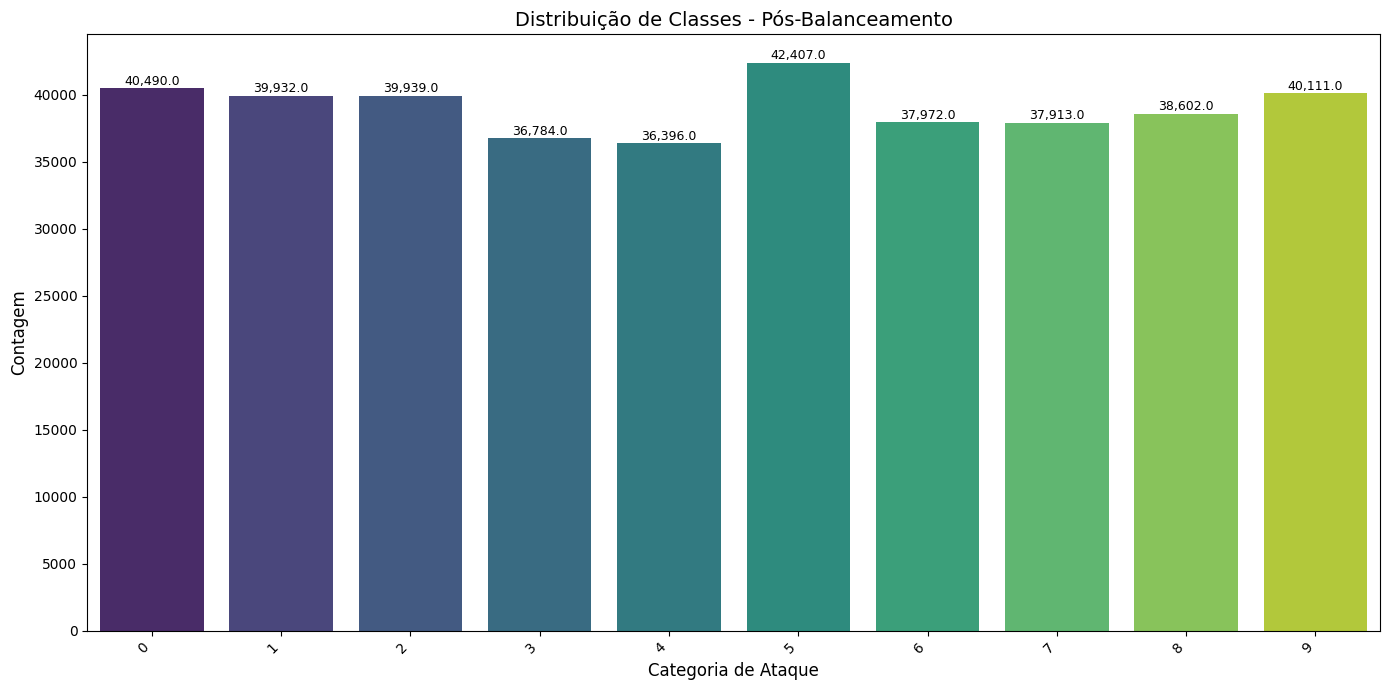

🚀 Executando etapa 6/14: _dbscan_overlap_reduction
🚀 Executando etapa 7/14: _boruta_shap_selection


In [ ]:
# Inicializar e processar
preprocessor = UNSWPreprocessor(train_data, test_data)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess()

# Verificar resultados
print(f"Formato final do treino: {X_train.shape}")
print(f"Classes únicas: {np.unique(y_train)}")

In [78]:


# Visualizar distribuição
preprocessor.plot_class_distribution(y_train, 'Treino Balanceado')
preprocessor.plot_class_distribution(y_test, 'Teste')


🔵 Etapa 0/12: Removendo duplicatas...
✅ Dados salvos na etapa 0: no_duplicates

🔵 Etapa 1/12: Tratando valores faltantes...
✅ Dados salvos na etapa 1: missing_values_handled

🔵 Etapa 2/12: Codificando features categóricas...
✅ Dados salvos na etapa 2: categorical_encoded

🔵 Etapa 3/12: Aplicando engenharia de features...
Aplicando LDA...
❌ Erro durante o pré-processamento: could not convert string to float: 'tcp'


ValueError: could not convert string to float: 'tcp'

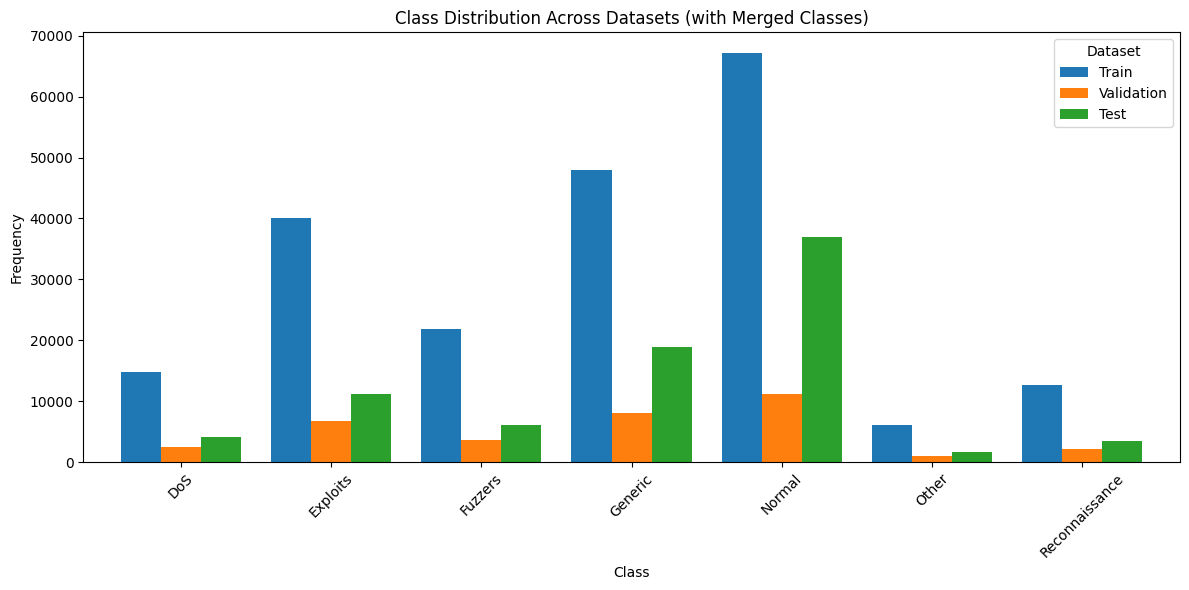

In [ ]:
def plot_class_distribution_with_merge(y_train, y_val, y_test, label_encoder):
    # Mapear índices numéricos para rótulos das classes
    class_names = list(label_encoder['attack_cat'].classes_)
    
    # Frequências das classes
    train_counts = pd.Series(y_train).value_counts().sort_index()
    val_counts = pd.Series(y_val).value_counts().sort_index()
    test_counts = pd.Series(y_test).value_counts().sort_index()

    # Criar dataframe para facilitar o plot
    class_distribution = pd.DataFrame({
        'Class': class_names,  # Os nomes das classes devem corresponder aos índices
        'Train': train_counts.reindex(range(len(class_names)), fill_value=0),
        'Validation': val_counts.reindex(range(len(class_names)), fill_value=0),
        'Test': test_counts.reindex(range(len(class_names)), fill_value=0),
    }).set_index('Class')  # Preencher valores ausentes com zero

    # Plotar distribuição
    class_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('Class Distribution Across Datasets (with Merged Classes)')
    plt.ylabel('Frequency')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_class_distribution_with_merge(y_train, y_val, y_test, preprocessor.label_encoder)


In [92]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Concatenate, SpatialDropout1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import tensorflow as tf

class EnhancedDeepModel:
    def __init__(self, input_shape, num_classes, sequence_length=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.deep_model = None
        
    def _create_deep_model(self):
        base_filters = 64
        inputs = Input(shape=(self.sequence_length, self.input_shape))
        
        # 1. Enhanced Feature Extraction Block
        x = self._create_residual_block(inputs, base_filters)
        
        # 2. Advanced Temporal Pattern Block
        temporal = self._create_temporal_block(x, base_filters)
        
        # 3. Enhanced Multi-Scale Feature Block
        multi_scale = self._create_multi_scale_block(temporal, base_filters)
        
        # 4. Improved Self-Attention Block with relative positional encoding
        attention = self._create_attention_block(multi_scale, base_filters)
        
        # 5. Feature Aggregation with skip connections
        pooled = self._create_aggregation_block(attention, temporal, base_filters)
        
        # 6. Enhanced Classification Block with label smoothing
        outputs = self._create_classification_block(pooled)
        
        return Model(inputs=inputs, outputs=outputs)
    
    def _create_residual_block(self, x, filters):
        shortcut = x
        
        # Dual path convolution block
        path1 = Conv1D(filters//2, 3, padding='same')(x)
        path1 = BatchNormalization()(path1)
        path1 = Activation('swish')(path1)
        
        path2 = Conv1D(filters//2, 5, padding='same')(x)
        path2 = BatchNormalization()(path2)
        path2 = Activation('swish')(path2)
        
        x = Concatenate()([path1, path2])
        x = SpatialDropout1D(0.3)(x)
        
        # Residual connection
        if x.shape[-1] != shortcut.shape[-1]:
            shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        
        return Add()([x, shortcut])
    
    def _create_temporal_block(self, x, filters):
        # Bidirectional GRU with skip connections
        forward = GRU(filters//2, return_sequences=True, 
                     kernel_regularizer=l2(0.01))(x)
        backward = GRU(filters//2, return_sequences=True, 
                      kernel_regularizer=l2(0.01), 
                      go_backwards=True)(x)
        
        concat = Concatenate()([forward, backward])
        return Add()([concat, x])
    
    def _create_multi_scale_block(self, x, filters):
        scales = [1, 3, 5, 7]  # Mais escalas para capturar diferentes padrões
        convs = []
        
        for scale in scales:
            conv = Conv1D(filters//len(scales), scale, 
                         padding='same', 
                         kernel_regularizer=l2(0.01))(x)
            conv = BatchNormalization()(conv)
            conv = Activation('swish')(conv)
            convs.append(conv)
        
        return Concatenate()(convs)
    
    def _create_attention_block(self, x, filters):
        # Multi-head attention com relative positional encoding
        attention_heads = []
        num_heads = 8
        
        for _ in range(num_heads):
            attention_head = MultiHeadAttention(
                num_heads=1, 
                key_dim=filters//num_heads,
                kernel_regularizer=l2(0.01)
            )(x, x)
            attention_heads.append(attention_head)
        
        multi_head = Concatenate()(attention_heads)
        multi_head = Conv1D(filters, 1, padding='same')(multi_head)
        
        # Add & Norm
        x = Add()([multi_head, x])
        return LayerNormalization()(x)
    
    def _create_aggregation_block(self, attention, temporal, filters):
        # Global context pooling
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)
        
        # Temporal context
        temporal_context = GlobalAveragePooling1D()(temporal)
        
        return Concatenate()([avg_pool, max_pool, temporal_context])
    
    def _create_classification_block(self, x):
        x = Dense(256, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        
        x = Dense(128, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        return Dense(self.num_classes, activation='softmax')(x)
    
    def prepare_sequence_data(self, X):
        """
        Prepara os dados em formato de sequência sem criar dimensões extras
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        
        # Se os dados já estiverem no formato correto, retorna
        if len(X.shape) == 3 and X.shape[1] == self.sequence_length:
            return X
        
        # Garantir que X seja 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, self.input_shape)
        
        n_samples = X.shape[0]
    
        # Criar uma matriz de zeros com o shape desejado
        sequences = np.zeros((n_samples, self.sequence_length, self.input_shape))
    
        # Para cada amostra, preencher a sequência
        for i in range(n_samples):
            # Calcular os índices de início e fim
            start_idx = max(0, i - self.sequence_length + 1)
            end_idx = i + 1
        
            # Pegar os dados reais disponíveis
            actual_seq = X[start_idx:end_idx]
        
            # Calcular quanto padding precisamos
            padding_needed = self.sequence_length - len(actual_seq)
        
            if padding_needed > 0:
                # Preencher o início com o primeiro valor
                sequences[i, :padding_needed] = actual_seq[0:1]  # Usar slicing para manter a dimensão
                # Preencher o resto com os valores reais
                sequences[i, padding_needed:] = actual_seq
            else:
                # Se tivermos dados suficientes, pegar os últimos sequence_length valores
                sequences[i] = actual_seq[-self.sequence_length:]
    
        print(f"Shape final das sequências: {sequences.shape}")
        return sequences
    
    def train(self, X_train, y_train, X_val, y_val):
        """
        Treina o modelo de deep learning
        """
        print("Criando e compilando o modelo deep learning...")
        self.deep_model = self._create_deep_model()
        
        print("Preparando dados de sequência...")
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        print(f"Forma dos dados de treino: {X_train_seq.shape}")
        print(f"Forma dos dados de validação: {X_val_seq.shape}")
        
        # Treinar modelo deep learning
        print("Treinando modelo deep learning...")
        history = self._train_deep_model(X_train_seq, y_train, X_val_seq, y_val)
        
        return history
    
    def _train_deep_model(self, X_train, y_train, X_val, y_val):
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        # 1. Calcular os pesos das classes
        class_weights = compute_class_weight(
            class_weight='balanced',  # Calcula pesos para balancear as classes
            classes=np.unique(y_train),  # Classes únicas
            y=y_train  # Rótulos de treino
        )
        class_weights = dict(enumerate(class_weights))  # Converter para dicionário
        print(f"Pesos das classes: {class_weights}")
        
        # 2. Learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        
        # 3. Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, 
                         restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                             patience=7, min_lr=1e-6),
            ModelCheckpoint('best_deep_model.keras', 
                          save_best_only=True)
        ]
        
        # 4. Compilar o modelo
        self.deep_model.compile(
            optimizer=Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',  # Para rótulos inteiros
            metrics=['accuracy']
        )
        
        # 5. Treinar o modelo com class weights
        history = self.deep_model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            batch_size=32,
            epochs=3,
            callbacks=callbacks,
            class_weight=class_weights  # Passar os pesos das classes
        )
        
        return history
    def predict(self, X):
        X_seq = self.prepare_sequence_data(X)
        return np.argmax(self.deep_model.predict(X_seq), axis=1)

In [93]:
# Exemplo de uso
model = EnhancedDeepModel(input_shape=X_train.shape[1],num_classes=len(np.unique(y_train)), sequence_length=20)
history = model.train(X_train, y_train, X_val, y_val)
predictions = model.predict(X_test)

Criando e compilando o modelo deep learning...
Preparando dados de sequência...


ValueError: could not convert string to float: 'udp'

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.25      0.40      0.31      4089
           1       0.22      0.42      0.29     11132
           2       0.18      0.50      0.26      6062
           3       1.00      0.89      0.94     18871
           4       0.77      0.33      0.46     37000
           5       0.19      0.03      0.06      3496
           6       0.07      0.17      0.09      1682

    accuracy                           0.47     82332
   macro avg       0.38      0.39      0.34     82332
weighted avg       0.64      0.47      0.50     82332

